# Settings

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Useful packages
import numpy as np
import math
from scipy import stats

from astropy.io import fits
from astropy.table import Table
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

# Data

In [2]:
# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

# Bins

In [3]:
# redshift bins
z_0 = 0.0
z_1 = 0.05
halos_bin_z =[]

for i in range(60):
    cut_z = np.logical_and (dt_halos['redshift_true'] > z_0, dt_halos['redshift_true'] < z_1)
    halos_bin_z.append(dt_halos[cut_z])
    z_0 = z_0 + 0.05
    z_1 = z_1 + 0.05

# mass bins
label = []
halos_bin_mz =[]
for i in range(60):
    
    lnM_0 = min(lnM)
    lnM_1 = min(lnM) + 0.25
    for j in range(18):
        
        cut = np.logical_and (np.log(halos_bin_z[i]["m200c"]) > lnM_0, np.log(halos_bin_z[i]["m200c"]) < lnM_1)
        halos_bin_mz.append(halos_bin_z[i][cut])
        label.append(f"{min(halos_bin_z[i]['redshift_true']):.3f} < z < {max(halos_bin_z[i]['redshift_true']):.3f}\n{lnM_0:.3f} < lnM < {lnM_1:.3f}")
        
        lnM_0 = lnM_0 + 0.25
        lnM_1 = lnM_1 + 0.25

## Binned fit - mu0

In [4]:
# redshift bins
z_0 = 0.0
z_1 = 0.05
halos_bin_z =[]

for i in range(60):
    cut_z = np.logical_and (dt_halos['redshift_true'] > z_0, dt_halos['redshift_true'] < z_1)
    halos_bin_z.append(dt_halos[cut_z])
    z_0 = z_0 + 0.05
    z_1 = z_1 + 0.05

# mass bins
label = []
halos_bin_mz =[]
for i in range(60):
    
    lnM_0 = min(lnM)
    lnM_1 = min(lnM) + 0.25
    for j in range(18):
        
        cut = np.logical_and (np.log(halos_bin_z[i]["m200c"]) > lnM_0, np.log(halos_bin_z[i]["m200c"]) < lnM_1)
        halos_bin_mz.append(halos_bin_z[i][cut])
        label.append(f"{min(halos_bin_z[i]['redshift_true']):.3f} < z < {max(halos_bin_z[i]['redshift_true']):.3f}\n{lnM_0:.3f} < lnM < {lnM_1:.3f}")
        
        lnM_0 = lnM_0 + 0.25
        lnM_1 = lnM_1 + 0.25

In [5]:
def compute_res(rich_model):

    lnR_mean = np.array(
        [rich_model.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    lnR_std = np.array(
        [rich_model.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    
    lnr_cut = np.array(
        [rich_model.get_cut(lnM[i], z[i]) for i in range(len(dt_halos))])

    abs_err = (lnR - lnR_mean) / lnR_std
    # Data cut
    sigma_cut = 5.0

#     sigma_cut_array = np.abs(abs_err) < sigma_cut
#     print(f"Cutting {sigma_cut}-sigma, {np.sum(np.logical_not(sigma_cut_array))}")

#     lnR_mean = lnR_mean[sigma_cut_array]
#     z_sigma_cut = z[sigma_cut_array]
#     lnM_sigma_cut = lnM[sigma_cut_array]
#     abs_err = abs_err[sigma_cut_array]
#     lnR_ext = lnR[sigma_cut_array]
#     lnr_cut = lnr_cut[sigma_cut_array] 
    
    lnR_mean = lnR_mean
    z_sigma_cut = z
    lnM_sigma_cut = lnM
    abs_err = abs_err
    lnR_ext = lnR
    lnr_cut = lnr_cut
    
    
    return abs_err, lnR_mean, z_sigma_cut, lnM_sigma_cut, lnr_cut, lnR_ext 


fit_results_ascaso = []
fit_results_ext = []

mean_ext_list=[]

for i in range(len(halos_bin_mz)):
    
    if len(halos_bin_mz[i]) == 0:
        fit_results_ascaso.append(([], [], [], [], [] ,[]))
        fit_results_ext.append(([], [], [], [], [] ,[]))

    
    else:
        rmdata = create_richness_mass_calib(halos_bin_mz[i])

        use_ascaso = False

        ascaso = Nc.ClusterMassAscaso()

        ascaso.param_set_by_name("mup0", 4.45393539397061)
        ascaso.param_set_by_name("cut", 1e15)
        ascaso.param_set_by_name("mup1", 0.0)
        ascaso.param_set_by_name("mup2", 0.0)
        ascaso.param_set_by_name("sigmap0", 0.227197277810533)
        ascaso.param_set_by_name("sigmap1", 0.0)
        ascaso.param_set_by_name("sigmap2", 0.0)


        ascaso.param_set_ftype(0, Ncm.ParamType.FREE)
        ascaso.param_set_ftype(1, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(2, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(3, Ncm.ParamType.FREE)
        ascaso.param_set_ftype(4, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(5, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(6, Ncm.ParamType.FIXED)

        lnrich_ext = Nc.ClusterMassLnrichExt()
        lnrich_ext.param_set_by_name("mu", 4.60456407051582)   
        lnrich_ext.param_set_by_name("muM1", 0.0)
        lnrich_ext.param_set_by_name("muZ1", 0.0)
        lnrich_ext.param_set_by_name("muM2", 0.0)
        lnrich_ext.param_set_by_name("muZ2", 0.0)
        lnrich_ext.param_set_by_name("muMZ", 0.0)
        
        lnrich_ext.param_set_by_name("sigma0", 0.288099083637692)        
        lnrich_ext.param_set_by_name("sigmaM1", 0.0)
        lnrich_ext.param_set_by_name("sigmaZ1", 0.0)
        lnrich_ext.param_set_by_name("sigmaM2", 0.0)
        lnrich_ext.param_set_by_name("sigmaZ2", 0.0)
        lnrich_ext.param_set_by_name("sigmaMZ", 0.0)


        lnrich_ext.param_set_by_name("cut", 1e15)
        lnrich_ext.param_set_by_name("cutM1", 0)
        lnrich_ext.param_set_by_name("cutZ1", 0)


        lnrich_ext.param_set_ftype(0, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(1, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(2, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(3, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(4, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(5, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(6, Ncm.ParamType.FIXED)

        lnrich_ext.param_set_ftype(7, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(8, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(9, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(10, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(11, Ncm.ParamType.FIXED)

        lnrich_ext.param_set_ftype(12, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(13, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(14, Ncm.ParamType.FIXED)

        mset_ascaso = Ncm.MSet()
        mset_ascaso.set(ascaso)

        mset_ext = Ncm.MSet()
        mset_ext.set(lnrich_ext)

        dset = Ncm.Dataset.new()
        dset.append_data(rmdata)

        lh = Ncm.Likelihood.new(dset)

        fit_ascaso = Ncm.Fit.factory(
            Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ascaso, Ncm.FitGradType.NUMDIFF_CENTRAL)

        fit_ext = Ncm.Fit.factory(
            Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ext, Ncm.FitGradType.NUMDIFF_CENTRAL)

        fit_ascaso.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
        fit_ext.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
        
        
        dt_halos = halos_bin_mz[i]
        lnM = np.log(dt_halos["m200c"])  # ln(mass)
        z = dt_halos["redshift_true"]  # redshift
        lnR = np.log(dt_halos["richness"])  # ln(richness)

        res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso  = compute_res(ascaso)

        res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext  = compute_res(lnrich_ext)

        fit_results_ascaso.append((res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso))
        fit_results_ext.append((res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext))
        mean_ext_list.append(lnR_mean_ext)

#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0060060
#  iteration            [000070]
#  function evaluations [000072]
#  gradient evaluations [000000]
#  degrees of freedom   [000022]
#  m2lnL     =     20.8185175226137 (     20.818518 )
#  Fit parameters:
#     1.38052546327212     0.467945121112878   
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 4434.86879870702      
#  - relative improvement: 0.995327652942166     
#  - m2lnL_0  :            4455.68731622963      
#  - m2lnL_1  :            20.8185175226137      
#-------------------------------------------------------------------

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#  - relative improvement: 0.0415471536985224    
#  - m2lnL_2  :            126.884103985893      
#  - m2lnL_3  :            121.612430615692      
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0036340
#  iteration            [000047]
#  function evaluations [000049]
#  gradient evaluations [000000]
#  degrees of freedom   [000166]
#  m2lnL     =     121.612430615692 (     121.61243 )
#  Fit parameters:
#     1.7755710882475     -0.0437381295709043  
#----------------------------------------------------------------------------------
# Restarting:              no
#  - absolute improvement: 0                     
#  - relative improvement: 0                     
#  - m2lnL_3  :       

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 4.00608674000711    -0.142710564850235   
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 13.450615047635       
#  - relative improvement: 1.27513533406358      
#  - m2lnL_0  :            10.5483823468139      
#  - m2lnL_1  :            -2.90223270082106     
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0034860
#  iteration            [000046]
#  function evaluations [000048]
#  gradient evaluations [000000]
#  degrees of freedom   [000001]
#  m2lnL     =    -2.90223270082106 (    -2.9022327 )
#  Fit parameters:
#     4.00608674000711    -0.142710564850235   
#---------------------------

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0045560
#  iteration            [000043]
#  function evaluations [000045]
#  gradient evaluations [000000]
#  degrees of freedom   [000003]
#  m2lnL     =    -1.00608733464754 (    -1.0060873 )
#  Fit parameters:
#     4.03486507139955     0.174026490534109   
#----------------------------------------------------------------------------------
# Restarting:              no
#  - absolute improvement: 4.55313342584418e-10  
#  - relative improvement: -4.52558467948491e-10 
#  - m2lnL_1  :            -1.00608733419223     
#  - m2lnL_2  :            -1.00608733464754     
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Restarting:              yes
#  - absolute improvement: 6842.96454583613      
#  - relative improvement: 0.98974260117784      
#  - m2lnL_0  :            6913.88300118908      
#  - m2lnL_1  :            70.9184553529485      
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#..............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0038050
#  iteration            [000050]
#  function evaluations [000052]
#  gradient evaluations [000000]
#  degrees of freedom   [000201]
#  m2lnL     =     70.9184553529485 (     70.918455 )
#  Fit parameters:
#     2.93647232029285    -0.0395040382669941  
#----------------------------------------------------------------------------------
# Restarting:              no
#  - absolute improvement: 0            

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0054250
#  iteration            [000075]
#  function evaluations [000077]
#  gradient evaluations [000000]
#  degrees of freedom   [000335]
#  m2lnL     =    -4.57653285951977 (    -4.5765329 )
#  Fit parameters:
#     3.18941174944103     0.301215976025043   
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 10504.5182344262      
#  - relative improvement: 1.00043586269235      
#  - m2lnL_0  :            10499.9417015667      
#  - m2lnL_1  :            -4.57653285951977     
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#  - relative improvement: 0.640029222641509     
#  - m2lnL_2  :            1467.22256697261      
#  - m2lnL_3  :            528.157247991052      
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0101550
#  iteration            [000049]
#  function evaluations [000051]
#  gradient evaluations [000000]
#  degrees of freedom   [001503]
#  m2lnL     =     528.157247991052 (     528.15725 )
#  Fit parameters:
#     2.49952541768517    -0.0255622591085398  
#----------------------------------------------------------------------------------
# Restarting:              no
#  - absolute improvement: 0                     
#  - relative improvement: 0                     
#  - m2lnL_3  :       

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#  - differentiation:   Numerical differentiantion (central)
#..............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0027080
#  iteration            [000055]
#  function evaluations [000057]
#  gradient evaluations [000000]
#  degrees of freedom   [-00001]
#  m2lnL     =    -15.7681989422169 (    -15.768199 )
#  Fit parameters:
#     4.77079331856273    -0.467310485839844   
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 6.61829499141993      
#  - relative improvement: -0.723318520829224    
#  - m2lnL_1  :            -9.14990395079696     
#  - m2lnL_2  :            -15.7681989422169     
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



........
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0047430
#  iteration            [000048]
#  function evaluations [000050]
#  gradient evaluations [000000]
#  degrees of freedom   [000052]
#  m2lnL     =    -33.9577550334756 (    -33.957755 )
#  Fit parameters:
#     4.15634118759441     0.221446629030402   
#----------------------------------------------------------------------------------
# Restarting:              no
#  - absolute improvement: 0                     
#  - relative improvement: -0                    
#  - m2lnL_1  :            -33.9577550334756     
#  - m2lnL_2  :            -33.9577550334756     
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.................
#  Minimum found with precision: |df|/f =  1.00000e-08 and 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



    64.425542 )
#  Fit parameters:
#     3.2303468393151     -0.0164059375730544  
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 12220.6176098491      
#  - relative improvement: 0.994755774054857     
#  - m2lnL_0  :            12285.0431518834      
#  - m2lnL_1  :            64.4255420343058      
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#..............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0064760
#  iteration            [000051]
#  function evaluations [000053]
#  gradient evaluations [000000]
#  degrees of freedom   [000534]
#  m2lnL     =      64.425541527402 (     64.425542 )
#  Fit parameters:
#     3.2303357293479     -0.016398

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



-0.0173658744313448  
#----------------------------------------------------------------------------------
# Restarting:              no
#  - absolute improvement: 0                     
#  - relative improvement: 0                     
#  - m2lnL_1  :            341.164333895864      
#  - m2lnL_2  :            341.164333895864      
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0084750
#  iteration            [000076]
#  function evaluations [000078]
#  gradient evaluations [000000]
#  degrees of freedom   [001116]
#  m2lnL     =      194.62652077026 (     194.62652 )
#  Fit parameters:
#     2.97075331543471     0.3308487960493     
#----------------------------------------------

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0101470
#  iteration            [000047]
#  function evaluations [000049]
#  gradient evaluations [000000]
#  degrees of freedom   [002324]
#  m2lnL     =     494.263756920908 (     494.26376 )
#  Fit parameters:
#     2.70800881329489     0.337256427785317   
#----------------------------------------------------------------------------------
# Restarting:              no
#  - absolute improvement: 1.31876993236801e-06  
#  - relative improvement: 2.66815017363364e-09  
#  - m2lnL_1  :            494.263758239678      
#  - m2lnL_2  :            494.263756920908      
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#...................
#  Minimum found with precision: |df|/f =  1.00000e

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



..........
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0290030
#  iteration            [000102]
#  function evaluations [000104]
#  gradient evaluations [000000]
#  degrees of freedom   [002962]
#  m2lnL     =     661.371092225143 (     661.37109 )
#  Fit parameters:
#     2.61558042349794    -0.0151080605902877  
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 141468.51484502       
#  - relative improvement: 0.995346713410316     
#  - m2lnL_0  :            142129.885937245      
#  - m2lnL_1  :            661.371092225143      
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#..............
#  Minimum found with precision: |df|/f =  1.00000e-08 and 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0156330
#  iteration            [000102]
#  function evaluations [000104]
#  gradient evaluations [000000]
#  degrees of freedom   [001416]
#  m2lnL     =      221.91968522739 (     221.91969 )
#  Fit parameters:
#     2.98909938120751    -0.0138627879668078  
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 44654.3204982649      
#  - relative improvement: 0.995054851201438     
#  - m2lnL_0  :            44876.2401834923      
#  - m2lnL_1  :            221.91968522739       
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0073680
#  iteration            [000050]
#  function evaluations [000052]
#  gradient evaluations [000000]
#  degrees of freedom   [001097]
#  m2lnL     =     39.9794371529879 (     39.979437 )
#  Fit parameters:
#     3.0877090417347     -0.00674187515368149 
#----------------------------------------------------------------------------------
# Restarting:              no
#  - absolute improvement: 0                     
#  - relative improvement: 0                     
#  - m2lnL_1  :            39.9794371529879      
#  - m2lnL_2  :            39.9794371529879      
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.................
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0025470
#  iteration            [000048]
#  function evaluations [000050]
#  gradient evaluations [000000]
#  degrees of freedom   [000006]
#  m2lnL     =    -3.62392243681498 (    -3.6239224 )
#  Fit parameters:
#     4.55885076462524     0.241798367655297   
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 1.7710682711432       
#  - relative improvement: -0.955859507972165    
#  - m2lnL_0  :            -1.85285416567178     
#  - m2lnL_1  :            -3.62392243681498     
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-nel

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



...........
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0047210
#  iteration            [000073]
#  function evaluations [000075]
#  gradient evaluations [000000]
#  degrees of freedom   [000223]
#  m2lnL     =    -28.8141329470116 (    -28.814133 )
#  Fit parameters:
#     3.49309006973178     0.284462917586275   
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 4050.81888127226      
#  - relative improvement: 1.00716412206102      
#  - m2lnL_0  :            4022.00474832525      
#  - m2lnL_1  :            -28.8141329470116     
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0069450
#  iteration            [000048]
#  function evaluations [000050]
#  gradient evaluations [000000]
#  degrees of freedom   [001328]
#  m2lnL     =      145.82176895957 (     145.82177 )
#  Fit parameters:
#     2.79611738013509     0.320348904092777   
#----------------------------------------------------------------------------------
# Restarting:              no
#  - absolute improvement: 0                     
#  - relative improvement: 0                     
#  - m2lnL_1  :            145.82176895957       
#  - m2lnL_2  :            145.82176895957       
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#...................
#  Minimum found with precision: |df|/f =  1.00000e-

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



#  degrees of freedom   [-00001]
#  m2lnL     =    -6.58057048684774 (    -6.5805705 )
#  Fit parameters:
#     4.31276719551582     0.1405859375        
#----------------------------------------------------------------------------------
# Restarting:              yes
#  - absolute improvement: 6.58448942490925      
#  - relative improvement: 1680.17185307776      
#  - m2lnL_0  :            0.003918938061513     
#  - m2lnL_1  :            -6.58057048684774     
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#...............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0027990
#  iteration            [000062]
#  function evaluations [000064]
#  gradient evaluations [000000]
#  degrees of freedom   [-00001]
#  m2lnL     =    -13.9382873797568 

In [6]:
# <lnR|M,z> = \mu_0 e dados binados

mu0_ascaso = [j for i, j, k, l, m, n in fit_results_ascaso if len(j)>0]

mean_z_ascaso = [k for i, j, k, l, m, n in fit_results_ascaso if len(k) > 0]

mean_lnM_ascaso = [l for i, j, k, l, m, n in fit_results_ascaso if len(l) > 0]

mu0 = np.concatenate(mu0_ascaso,  axis=None)
m_z = np.concatenate(mean_z_ascaso,  axis=None)
m_lnM = np.concatenate(mean_lnM_ascaso,  axis=None)

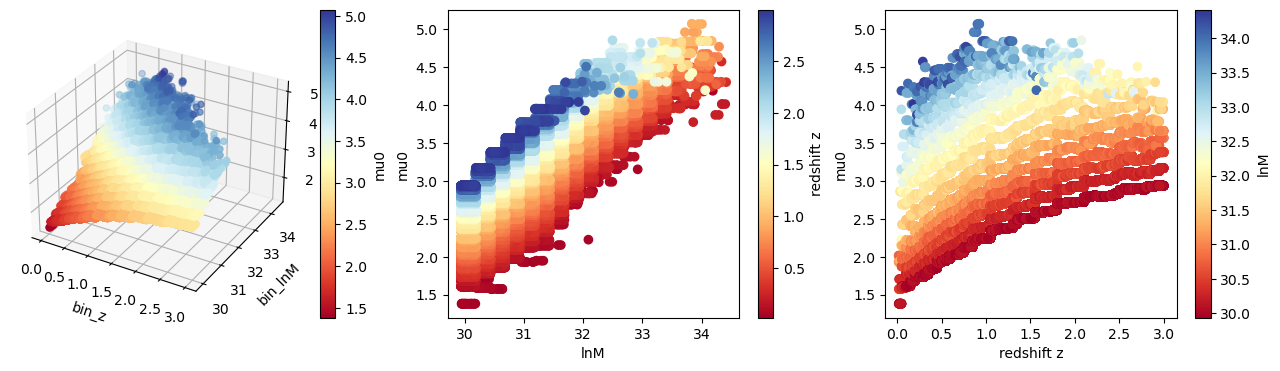

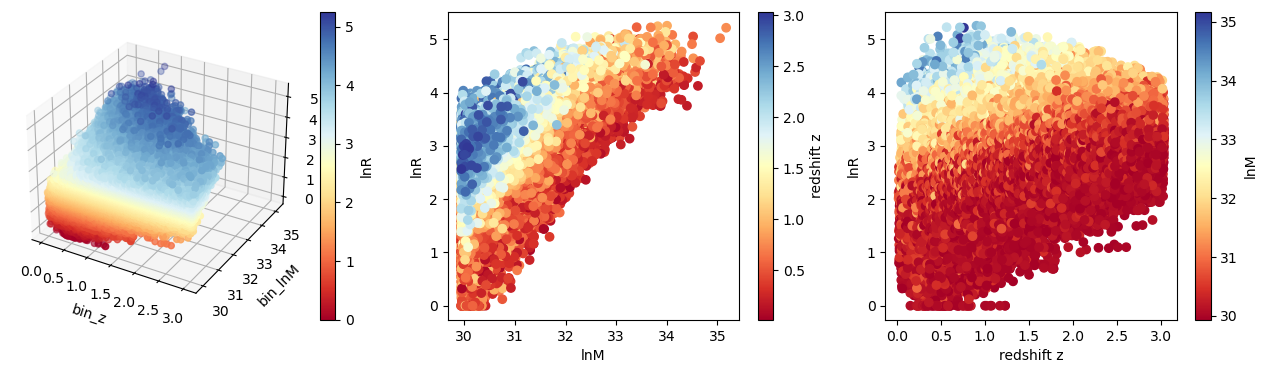

In [16]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

xs = m_z
ys = m_lnM
zs = mu0

p3 =ax1.scatter(xs, ys, zs, c=zs, cmap='RdYlBu')
ax1.set_xlabel('bin_z')
ax1.set_ylabel('bin_lnM')
#ax1.set_zlabel('mu0')
fig.colorbar(p3, ax=ax1, label='mu0')

p4 = ax2.scatter(m_lnM, mu0 , c= m_z, cmap='RdYlBu')
ax2.set_xlabel('lnM')
ax2.set_ylabel('mu0')
fig.colorbar(p4, ax=ax2, label='redshift z')

p5 = ax3.scatter(m_z, mu0 , c=m_lnM, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados
ax3.set_xlabel('redshift z')
ax3.set_ylabel('mu0')
fig.colorbar(p5, ax=ax3, label='lnM')

plt.show()

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

xs = z
ys = lnM
zs = lnR

p3 =ax1.scatter(xs, ys, zs, c=zs, cmap='RdYlBu')
ax1.set_xlabel('bin_z')
ax1.set_ylabel('bin_lnM')
#ax1.set_zlabel('mu0')
fig.colorbar(p3, ax=ax1, label='lnR')

p4 = ax2.scatter(lnM, lnR , c= z, cmap='RdYlBu')
ax2.set_xlabel('lnM')
ax2.set_ylabel('lnR')
fig.colorbar(p4, ax=ax2, label='redshift z')

p5 = ax3.scatter(z, lnR , c=lnM, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados
ax3.set_xlabel('redshift z')
ax3.set_ylabel('lnR')
fig.colorbar(p5, ax=ax3, label='lnM')

plt.show()

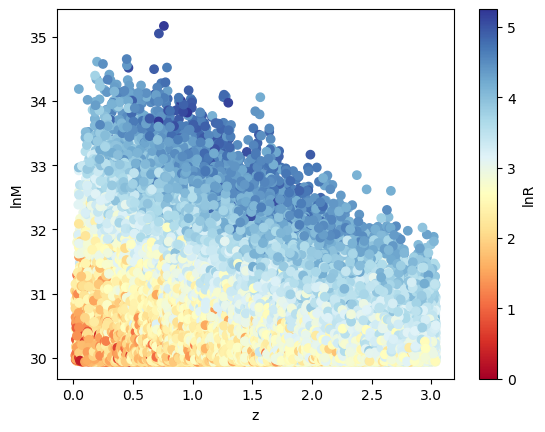

In [14]:
fig = plt.figure()

pmz=plt.scatter(z, lnM , c= lnR, cmap='RdYlBu')
plt.xlabel('z')
plt.ylabel('lnM')
fig.colorbar(pmz, label='lnR')

plt.show()
